In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import joblib
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

random_state = 42

In [23]:
def read_dataset(path, sep=';', encoding='utf-8-sig', low_memory=False):
    return pd.read_csv(path, sep=sep, encoding=encoding, low_memory=low_memory)

course_1_bak_spec = read_dataset("../../data/datasets/1st_course_bak_spec.csv")
course_1_magistr = read_dataset("../../data/datasets/1st_course_magistr.csv")

subjects_bak_spec = read_dataset("../../data/datasets/subjects_bak_spec.csv")
subjects_magistr = read_dataset("../../data/datasets/subjects_magistr.csv")

In [24]:
X_c1_bak_spec = course_1_bak_spec.drop(columns=["Таргет"])
y_c1_bak_spec = course_1_bak_spec["Таргет"]

X_train_c1_bak_spec, X_test_c1_bak_spec, y_train_c1_bak_spec, y_test_c1_bak_spec = train_test_split(
    X_c1_bak_spec,
    y_c1_bak_spec,
    test_size=0.2,
    random_state=random_state
)

X_c1_magistr = course_1_magistr.drop(columns=["Таргет"])
y_c1_magistr = course_1_magistr["Таргет"]

X_train_c1_magistr, X_test_c1_magistr, y_train_c1_magistr, y_test_c1_magistr = train_test_split(
    X_c1_magistr,
    y_c1_magistr,
    test_size=0.2,
    random_state=random_state
)

X_s_bak_spec = subjects_bak_spec.drop(columns=["Таргет"])
y_s_bak_spec = subjects_bak_spec["Таргет"]

X_train_s_bak_spec, X_test_s_bak_spec, y_train_s_bak_spec, y_test_s_bak_spec = train_test_split(
    X_s_bak_spec,
    y_s_bak_spec,
    test_size=0.2,
    random_state=random_state
)

X_s_magistr = subjects_magistr.drop(columns=["Таргет"])
y_s_magistr = subjects_magistr["Таргет"]

X_train_s_magistr, X_test_s_magistr, y_train_s_magistr, y_test_s_magistr = train_test_split(
    X_s_magistr,
    y_s_magistr,
    test_size=0.2,
    random_state=random_state
)

Лучшие параметры: {'clf__estimator__max_depth': 3, 'clf__learning_rate': 0.5, 'clf__n_estimators': 50}
Лучшая модель: Pipeline(steps=[('clf',
                 AdaBoostClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                                     max_depth=3),
                                    learning_rate=0.5, random_state=42))])

Отчёт классификации:
               precision    recall  f1-score   support

           0       0.97      0.87      0.92       117
           1       0.48      0.82      0.61        17

    accuracy                           0.87       134
   macro avg       0.73      0.85      0.76       134
weighted avg       0.91      0.87      0.88       134



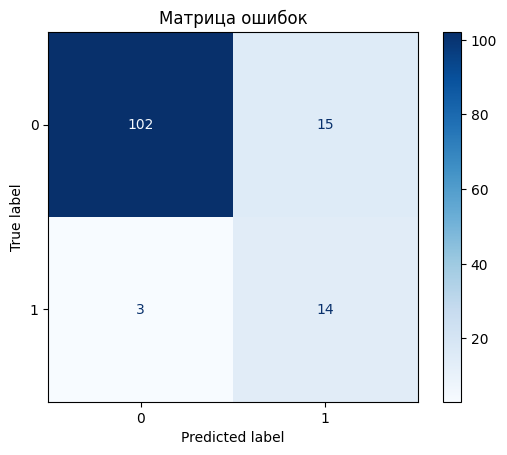


Feature Importances:
                                            feature  importance
37                      Позиция студента в рейтинге    0.452549
11                             fromSverdlovskRegion    0.089371
8                         Общее количество пересдач    0.002590
2                           Балл за инд. достижения    0.000000
0                                         Приоритет    0.000000
1                            Cумма баллов испытаний    0.000000
5                      Иностранный абитуриент (МОН)    0.000000
4                             Нуждается в общежитии    0.000000
3                                          Контракт    0.000000
9                           Общее количество долгов    0.000000
12                          Human Development Index    0.000000
10                                 fromEkaterinburg    0.000000
13                                     Особая квота    0.000000
6                                               Пол    0.000000
18                

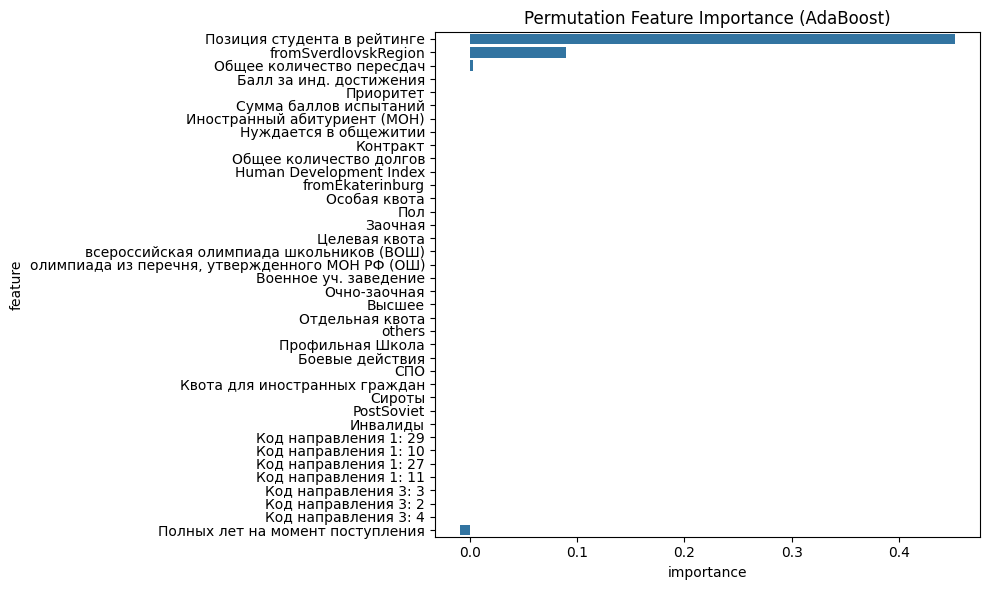

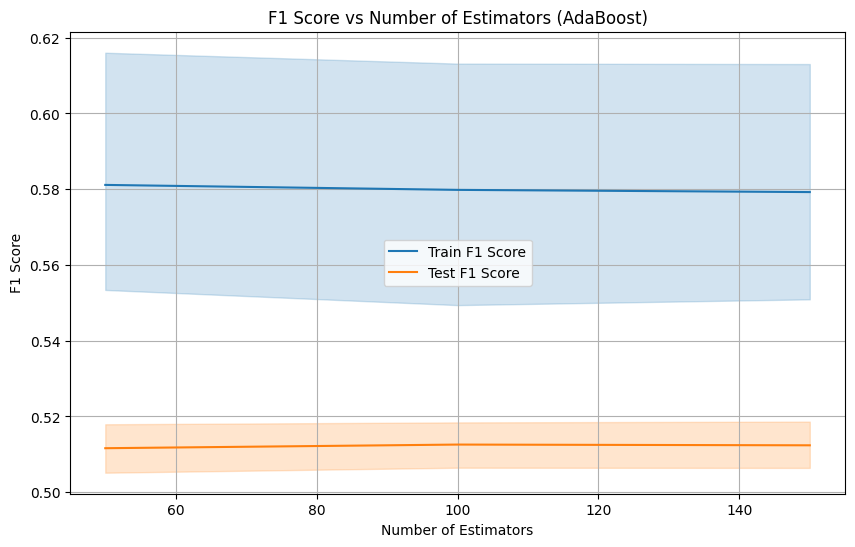

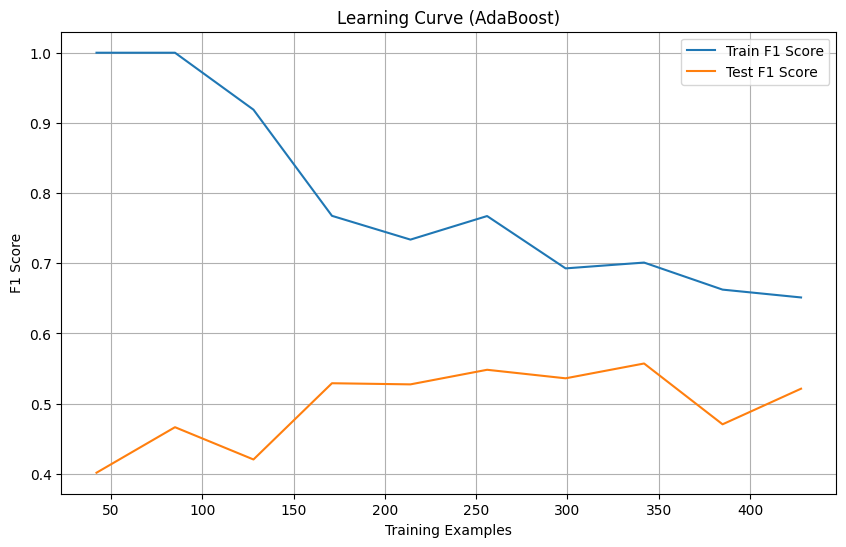

In [25]:
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import permutation_importance
import numpy as np
import os

save_dir = 'adaboost/s_magistr'
os.makedirs(save_dir, exist_ok=True)

pipeline = Pipeline([
    ('clf', AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=1, class_weight='balanced'),
        random_state=42
    ))
])

param_grid = {
    'clf__n_estimators': [50, 100, 150],
    'clf__learning_rate': [0.01, 0.1, 0.5, 1.0],
    'clf__estimator__max_depth': [2, 3]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1, return_train_score=True)
grid_search.fit(X_train_s_magistr, y_train_s_magistr)

y_pred = grid_search.predict(X_test_s_magistr)
best_model = grid_search.best_estimator_
joblib.dump(best_model, '../../data/models/adaboost_model_s_magistr.joblib')

print("Лучшие параметры:", grid_search.best_params_)
print("Лучшая модель:", best_model)
print("\nОтчёт классификации:\n", classification_report(y_test_s_magistr, y_pred))

cm = confusion_matrix(y_test_s_magistr, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.named_steps['clf'].classes_)
disp.plot(cmap="Blues")
plt.title("Матрица ошибок")
plt.savefig(os.path.join(save_dir, "confusion_matrix_adaboost.png"))
plt.show()

result = permutation_importance(
    best_model,
    X_test_s_magistr,
    y_test_s_magistr,
    scoring='f1',
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

importances = result.importances_mean
features = X_train_s_magistr.columns

feature_importances = pd.DataFrame({
    'feature': features,
    'importance': importances
}).sort_values('importance', ascending=False)

print("\nFeature Importances:")
print(feature_importances)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importances)
plt.title("Permutation Feature Importance (AdaBoost)")
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "feature_importance_adaboost.png"))
plt.show()

results = pd.DataFrame(grid_search.cv_results_)
results_filtered = results[[
    'param_clf__n_estimators',
    'mean_train_score',
    'mean_test_score'
]].copy()
results_filtered['param_clf__n_estimators'] = pd.to_numeric(results_filtered['param_clf__n_estimators'])

plt.figure(figsize=(10, 6))
sns.lineplot(data=results_filtered, x='param_clf__n_estimators', y='mean_train_score', label='Train F1 Score')
sns.lineplot(data=results_filtered, x='param_clf__n_estimators', y='mean_test_score', label='Test F1 Score')
plt.title('F1 Score vs Number of Estimators (AdaBoost)')
plt.xlabel('Number of Estimators')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(save_dir, "f1_vs_estimators_adaboost.png"))
plt.show()

train_sizes, train_scores, test_scores = learning_curve(
    estimator=best_model,
    X=X_train_s_magistr,
    y=y_train_s_magistr,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='f1',
    n_jobs=-1
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Train F1 Score')
plt.plot(train_sizes, test_scores_mean, label='Test F1 Score')
plt.title('Learning Curve (AdaBoost)')
plt.xlabel('Training Examples')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(save_dir, "learning_curve_adaboost.png"))
plt.show()

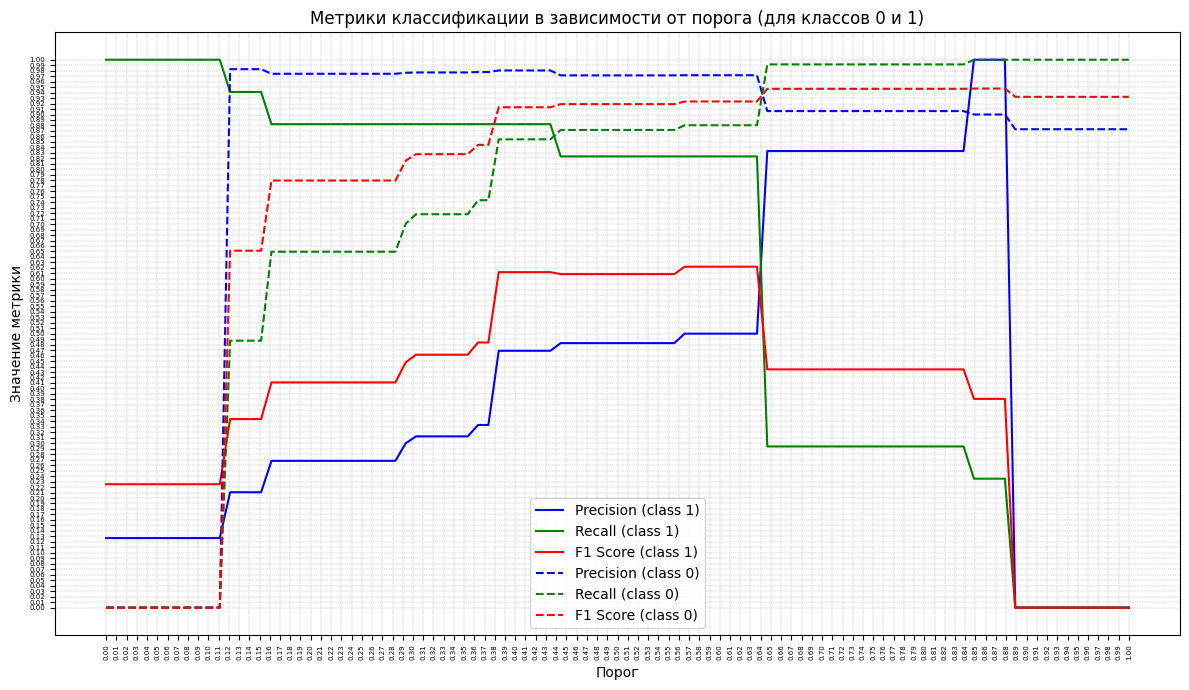

In [26]:
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np
import os

y_probs = grid_search.predict_proba(X_test_s_magistr)[:, 1]

thresholds = np.linspace(0, 1, 100)

precisions_1, recalls_1, f1_scores_1 = [], [], []
precisions_0, recalls_0, f1_scores_0 = [], [], []

for thresh in thresholds:
    y_pred_thresh = (y_probs >= thresh).astype(int)

    precisions_1.append(precision_score(y_test_s_magistr, y_pred_thresh, pos_label=1, zero_division=0))
    recalls_1.append(recall_score(y_test_s_magistr, y_pred_thresh, pos_label=1, zero_division=0))
    f1_scores_1.append(f1_score(y_test_s_magistr, y_pred_thresh, pos_label=1, zero_division=0))

    precisions_0.append(precision_score(y_test_s_magistr, y_pred_thresh, pos_label=0, zero_division=0))
    recalls_0.append(recall_score(y_test_s_magistr, y_pred_thresh, pos_label=0, zero_division=0))
    f1_scores_0.append(f1_score(y_test_s_magistr, y_pred_thresh, pos_label=0, zero_division=0))

save_path = 'adaboost/s_magistr'

plt.figure(figsize=(12, 7))

plt.plot(thresholds, precisions_1, label='Precision (class 1)', color='blue')
plt.plot(thresholds, recalls_1, label='Recall (class 1)', color='green')
plt.plot(thresholds, f1_scores_1, label='F1 Score (class 1)', color='red')

plt.plot(thresholds, precisions_0, '--', label='Precision (class 0)', color='blue')
plt.plot(thresholds, recalls_0, '--', label='Recall (class 0)', color='green')
plt.plot(thresholds, f1_scores_0, '--', label='F1 Score (class 0)', color='red')

plt.xticks(np.arange(0, 1.01, 0.01), rotation=90, fontsize=5)
plt.yticks(np.arange(0, 1.01, 0.01), fontsize=5)
plt.grid(True, which='both', linestyle='--', linewidth=0.3)

plt.xlabel('Порог')
plt.ylabel('Значение метрики')
plt.title('Метрики классификации в зависимости от порога (для классов 0 и 1)')
plt.legend()
plt.tight_layout()

plt.savefig(os.path.join(save_path, 'metrics_vs_threshold_adaboost.png'), dpi=300)
plt.show()

Лучшие параметры: {'clf__estimator__max_depth': 3, 'clf__learning_rate': 1.0, 'clf__n_estimators': 50}
Лучшая модель: Pipeline(steps=[('clf',
                 AdaBoostClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                                     max_depth=3),
                                    random_state=42))])

Отчёт классификации:
               precision    recall  f1-score   support

           0       0.97      0.86      0.91       271
           1       0.54      0.85      0.66        52

    accuracy                           0.86       323
   macro avg       0.75      0.85      0.78       323
weighted avg       0.90      0.86      0.87       323



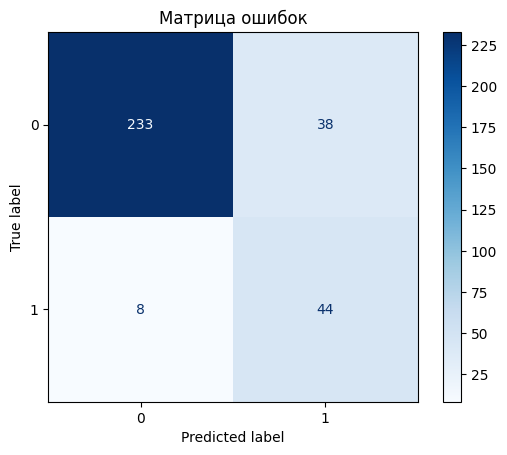


Feature Importances:
                                            feature  importance
10                          Общее количество долгов    0.439515
39                      Позиция студента в рейтинге    0.134310
7                                               Пол    0.008651
35                            Код направления 1: 29    0.002507
3                           Балл за инд. достижения    0.000000
0                                         Приоритет    0.000000
2                                               БВИ    0.000000
1                            Cумма баллов испытаний    0.000000
6                      Иностранный абитуриент (МОН)    0.000000
5                             Нуждается в общежитии    0.000000
4                                          Контракт    0.000000
8                  Полных лет на момент поступления    0.000000
12                             fromSverdlovskRegion    0.000000
13                          Human Development Index    0.000000
9                 

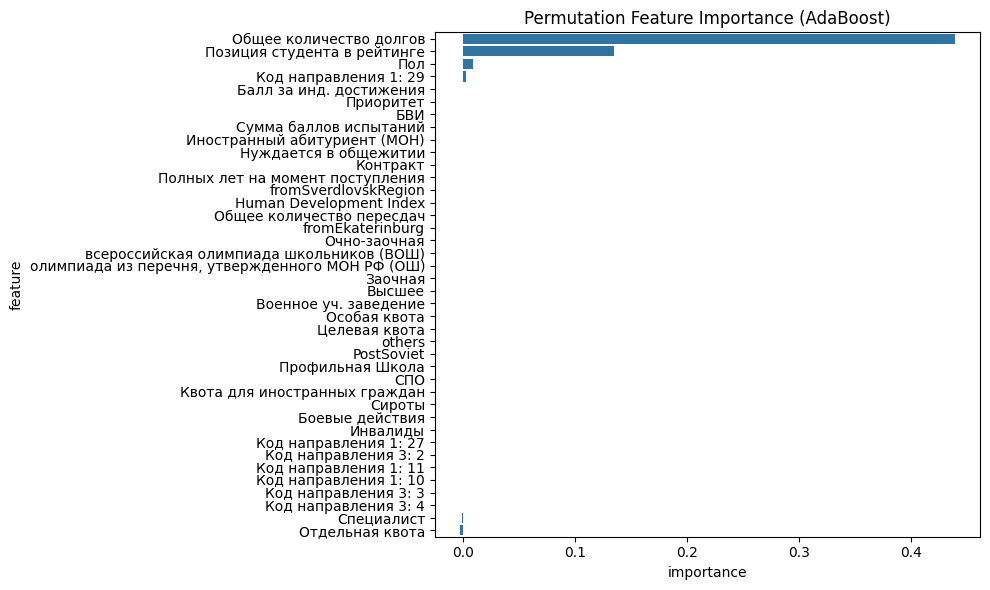

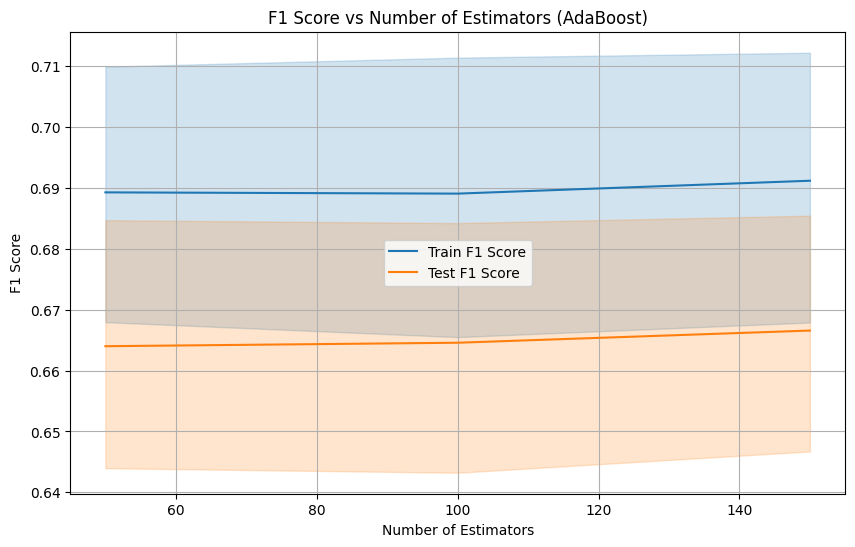

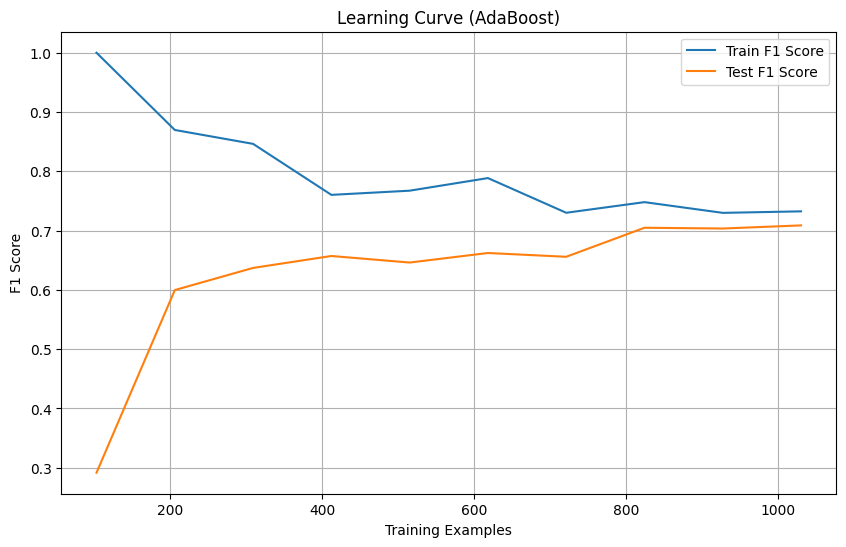

In [27]:
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import permutation_importance
import numpy as np
import os

save_dir = 'adaboost/s_bak_spec'
os.makedirs(save_dir, exist_ok=True)

pipeline = Pipeline([
    ('clf', AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=1, class_weight='balanced'),
        random_state=42
    ))
])

param_grid = {
    'clf__n_estimators': [50, 100, 150],
    'clf__learning_rate': [0.01, 0.1, 0.5, 1.0],
    'clf__estimator__max_depth': [2, 3]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1, return_train_score=True)
grid_search.fit(X_train_s_bak_spec, y_train_s_bak_spec)

y_pred = grid_search.predict(X_test_s_bak_spec)
best_model = grid_search.best_estimator_
joblib.dump(best_model, '../../data/models/adaboost_model_s_bak_spec.joblib')

print("Лучшие параметры:", grid_search.best_params_)
print("Лучшая модель:", best_model)
print("\nОтчёт классификации:\n", classification_report(y_test_s_bak_spec, y_pred))

cm = confusion_matrix(y_test_s_bak_spec, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.named_steps['clf'].classes_)
disp.plot(cmap="Blues")
plt.title("Матрица ошибок")
plt.savefig(os.path.join(save_dir, "confusion_matrix_adaboost.png"))
plt.show()

result = permutation_importance(
    best_model,
    X_test_s_bak_spec,
    y_test_s_bak_spec,
    scoring='f1',
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

importances = result.importances_mean
features = X_train_s_bak_spec.columns

feature_importances = pd.DataFrame({
    'feature': features,
    'importance': importances
}).sort_values('importance', ascending=False)

print("\nFeature Importances:")
print(feature_importances)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importances)
plt.title("Permutation Feature Importance (AdaBoost)")
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "feature_importance_adaboost.png"))
plt.show()

results = pd.DataFrame(grid_search.cv_results_)
results_filtered = results[[
    'param_clf__n_estimators',
    'mean_train_score',
    'mean_test_score'
]].copy()
results_filtered['param_clf__n_estimators'] = pd.to_numeric(results_filtered['param_clf__n_estimators'])

plt.figure(figsize=(10, 6))
sns.lineplot(data=results_filtered, x='param_clf__n_estimators', y='mean_train_score', label='Train F1 Score')
sns.lineplot(data=results_filtered, x='param_clf__n_estimators', y='mean_test_score', label='Test F1 Score')
plt.title('F1 Score vs Number of Estimators (AdaBoost)')
plt.xlabel('Number of Estimators')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(save_dir, "f1_vs_estimators_adaboost.png"))
plt.show()

train_sizes, train_scores, test_scores = learning_curve(
    estimator=best_model,
    X=X_train_s_bak_spec,
    y=y_train_s_bak_spec,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='f1',
    n_jobs=-1
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Train F1 Score')
plt.plot(train_sizes, test_scores_mean, label='Test F1 Score')
plt.title('Learning Curve (AdaBoost)')
plt.xlabel('Training Examples')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(save_dir, "learning_curve_adaboost.png"))
plt.show()

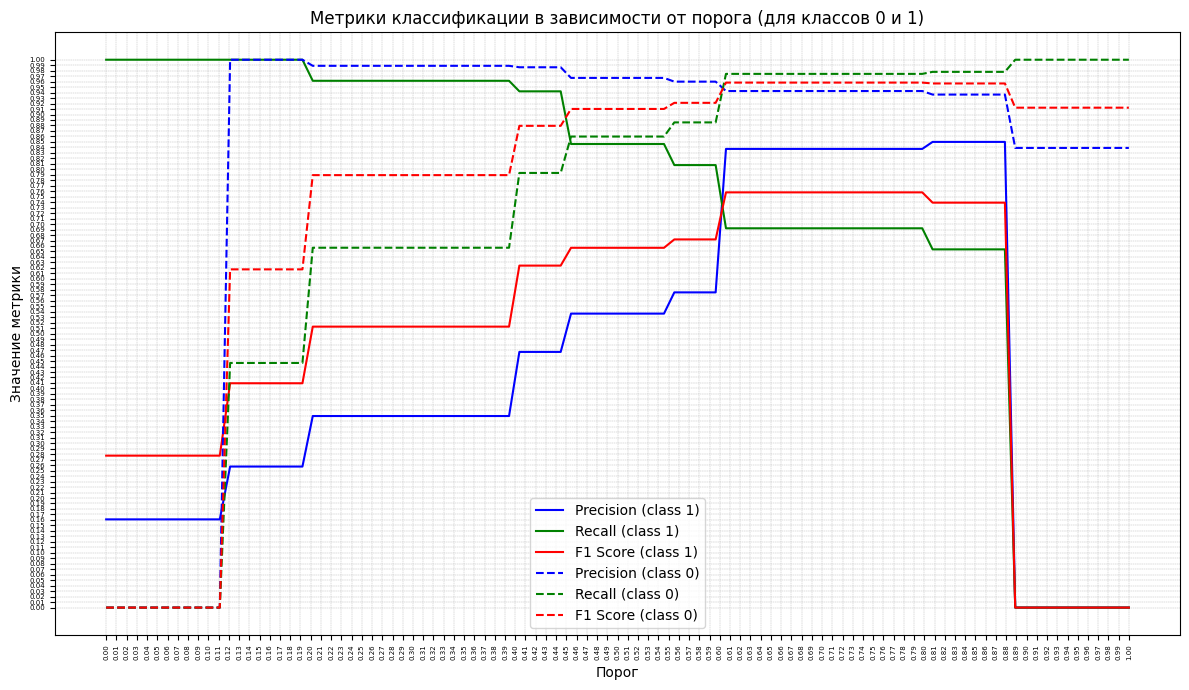

In [28]:
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np
import os

y_probs = grid_search.predict_proba(X_test_s_bak_spec)[:, 1]

thresholds = np.linspace(0, 1, 100)

precisions_1, recalls_1, f1_scores_1 = [], [], []
precisions_0, recalls_0, f1_scores_0 = [], [], []

for thresh in thresholds:
    y_pred_thresh = (y_probs >= thresh).astype(int)

    precisions_1.append(precision_score(y_test_s_bak_spec, y_pred_thresh, pos_label=1, zero_division=0))
    recalls_1.append(recall_score(y_test_s_bak_spec, y_pred_thresh, pos_label=1, zero_division=0))
    f1_scores_1.append(f1_score(y_test_s_bak_spec, y_pred_thresh, pos_label=1, zero_division=0))

    precisions_0.append(precision_score(y_test_s_bak_spec, y_pred_thresh, pos_label=0, zero_division=0))
    recalls_0.append(recall_score(y_test_s_bak_spec, y_pred_thresh, pos_label=0, zero_division=0))
    f1_scores_0.append(f1_score(y_test_s_bak_spec, y_pred_thresh, pos_label=0, zero_division=0))

save_path = 'adaboost/s_bak_spec'

plt.figure(figsize=(12, 7))

plt.plot(thresholds, precisions_1, label='Precision (class 1)', color='blue')
plt.plot(thresholds, recalls_1, label='Recall (class 1)', color='green')
plt.plot(thresholds, f1_scores_1, label='F1 Score (class 1)', color='red')

plt.plot(thresholds, precisions_0, '--', label='Precision (class 0)', color='blue')
plt.plot(thresholds, recalls_0, '--', label='Recall (class 0)', color='green')
plt.plot(thresholds, f1_scores_0, '--', label='F1 Score (class 0)', color='red')

plt.xticks(np.arange(0, 1.01, 0.01), rotation=90, fontsize=5)
plt.yticks(np.arange(0, 1.01, 0.01), fontsize=5)
plt.grid(True, which='both', linestyle='--', linewidth=0.3)

plt.xlabel('Порог')
plt.ylabel('Значение метрики')
plt.title('Метрики классификации в зависимости от порога (для классов 0 и 1)')
plt.legend()
plt.tight_layout()

plt.savefig(os.path.join(save_path, 'metrics_vs_threshold_adaboost.png'), dpi=300)
plt.show()

C:\Users\333\anaconda3\envs\pp\lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\333\anaconda3\envs\pp\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\333\anaconda3\envs\pp\lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\333\anaconda3\envs\pp\lib\site-packages\sklearn\pipeline.py", line 662, in fit
    self._final_estimator.fit(Xt, y, **last_step_param

Лучшие параметры: {'clf__estimator__max_depth': 2, 'clf__learning_rate': 0.01, 'clf__n_estimators': 50}
Лучшая модель: Pipeline(steps=[('clf',
                 AdaBoostClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                                     max_depth=2),
                                    learning_rate=0.01, random_state=42))])

Отчёт классификации:
               precision    recall  f1-score   support

           0       0.90      0.59      0.71       117
           1       0.16      0.53      0.24        17

    accuracy                           0.58       134
   macro avg       0.53      0.56      0.48       134
weighted avg       0.80      0.58      0.65       134



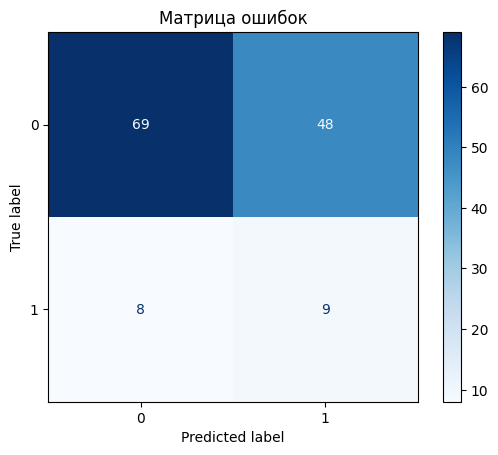


Feature Importances:
                                            feature  importance
7                  Полных лет на момент поступления    0.078378
1                            Cумма баллов испытаний    0.000000
0                                         Приоритет    0.000000
2                           Балл за инд. достижения    0.000000
3                                          Контракт    0.000000
5                      Иностранный абитуриент (МОН)    0.000000
4                             Нуждается в общежитии    0.000000
6                                               Пол    0.000000
8                                  fromEkaterinburg    0.000000
9                              fromSverdlovskRegion    0.000000
10                          Human Development Index    0.000000
11                                     Особая квота    0.000000
12                                  Отдельная квота    0.000000
13                                    Целевая квота    0.000000
14         всеросс

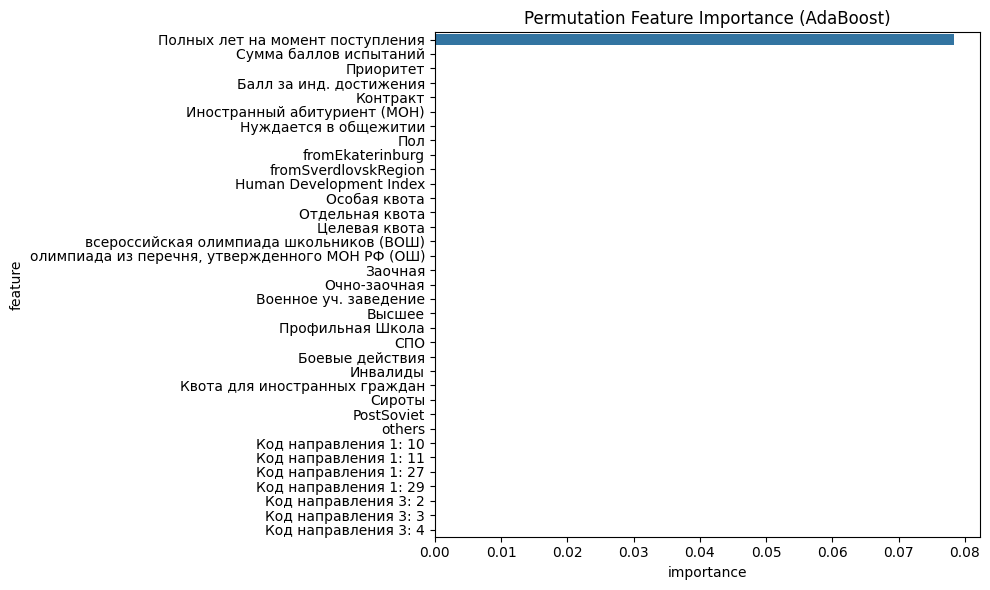

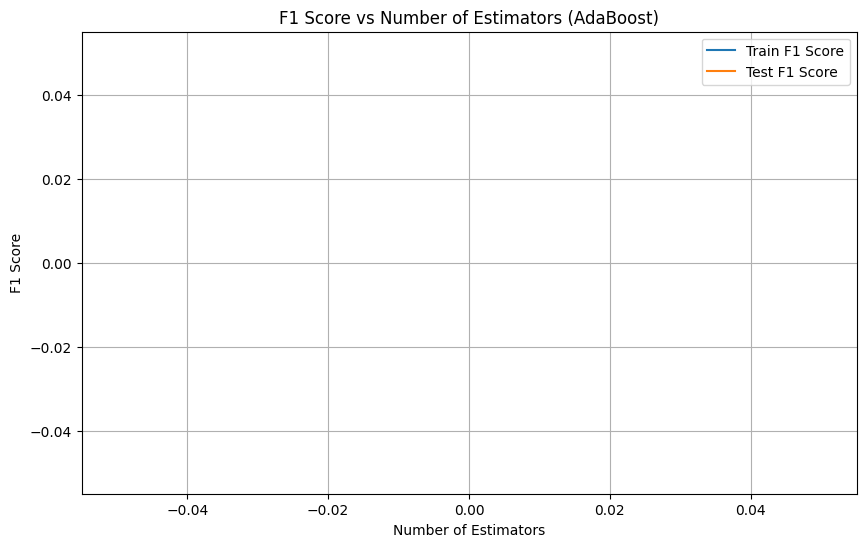

C:\Users\333\anaconda3\envs\pp\lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
18 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
18 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\333\anaconda3\envs\pp\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\333\anaconda3\envs\pp\lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\333\anaconda3\envs\pp\lib\site-packages\sklearn\pipeline.py", line 662, in fit
    self._final_estimator.fit(Xt, y, **last_step_params

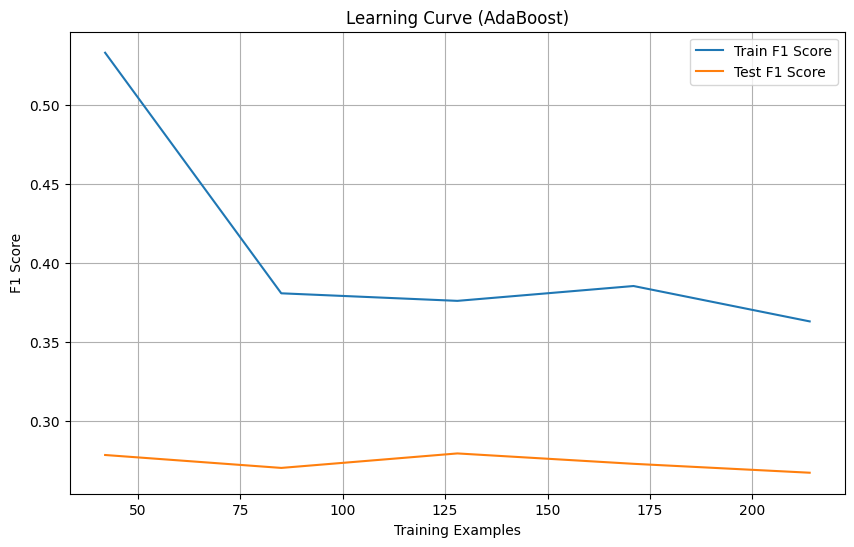

In [29]:
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import permutation_importance
import numpy as np
import os

save_dir = 'adaboost/c1_magistr'
os.makedirs(save_dir, exist_ok=True)

pipeline = Pipeline([
    ('clf', AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=1, class_weight='balanced'),
        random_state=42
    ))
])

param_grid = {
    'clf__n_estimators': [50, 100, 150],
    'clf__learning_rate': [0.01, 0.1, 0.5, 1.0],
    'clf__estimator__max_depth': [2, 3]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1, return_train_score=True)
grid_search.fit(X_train_c1_magistr, y_train_c1_magistr)

y_pred = grid_search.predict(X_test_c1_magistr)
best_model = grid_search.best_estimator_
joblib.dump(best_model, '../../data/models/adaboost_model_c1_magistr.joblib')

print("Лучшие параметры:", grid_search.best_params_)
print("Лучшая модель:", best_model)
print("\nОтчёт классификации:\n", classification_report(y_test_c1_magistr, y_pred))

cm = confusion_matrix(y_test_c1_magistr, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.named_steps['clf'].classes_)
disp.plot(cmap="Blues")
plt.title("Матрица ошибок")
plt.savefig(os.path.join(save_dir, "confusion_matrix_adaboost.png"))
plt.show()

result = permutation_importance(
    best_model,
    X_test_c1_magistr,
    y_test_c1_magistr,
    scoring='f1',
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

importances = result.importances_mean
features = X_train_c1_magistr.columns

feature_importances = pd.DataFrame({
    'feature': features,
    'importance': importances
}).sort_values('importance', ascending=False)

print("\nFeature Importances:")
print(feature_importances)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importances)
plt.title("Permutation Feature Importance (AdaBoost)")
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "feature_importance_adaboost.png"))
plt.show()

results = pd.DataFrame(grid_search.cv_results_)
results_filtered = results[[
    'param_clf__n_estimators',
    'mean_train_score',
    'mean_test_score'
]].copy()
results_filtered['param_clf__n_estimators'] = pd.to_numeric(results_filtered['param_clf__n_estimators'])

plt.figure(figsize=(10, 6))
sns.lineplot(data=results_filtered, x='param_clf__n_estimators', y='mean_train_score', label='Train F1 Score')
sns.lineplot(data=results_filtered, x='param_clf__n_estimators', y='mean_test_score', label='Test F1 Score')
plt.title('F1 Score vs Number of Estimators (AdaBoost)')
plt.xlabel('Number of Estimators')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(save_dir, "f1_vs_estimators_adaboost.png"))
plt.show()

train_sizes, train_scores, test_scores = learning_curve(
    estimator=best_model,
    X=X_train_c1_magistr,
    y=y_train_c1_magistr,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='f1',
    n_jobs=-1
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Train F1 Score')
plt.plot(train_sizes, test_scores_mean, label='Test F1 Score')
plt.title('Learning Curve (AdaBoost)')
plt.xlabel('Training Examples')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(save_dir, "learning_curve_adaboost.png"))
plt.show()

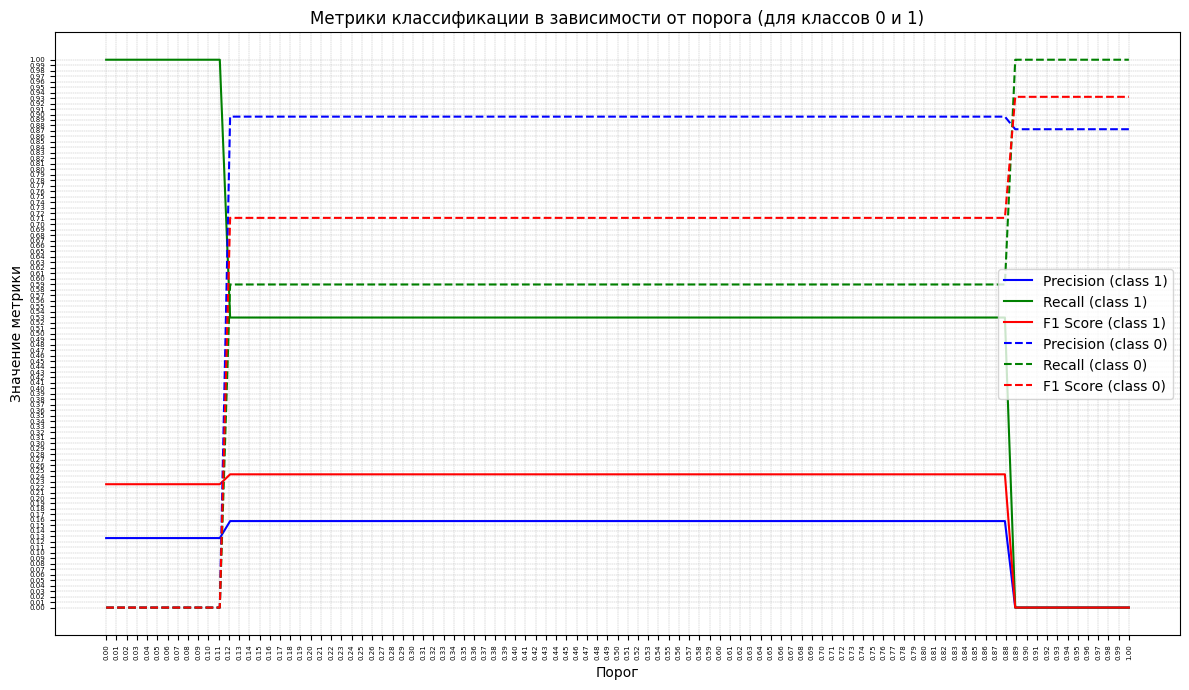

In [30]:
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np
import os

y_probs = grid_search.predict_proba(X_test_c1_magistr)[:, 1]

thresholds = np.linspace(0, 1, 100)

precisions_1, recalls_1, f1_scores_1 = [], [], []
precisions_0, recalls_0, f1_scores_0 = [], [], []

for thresh in thresholds:
    y_pred_thresh = (y_probs >= thresh).astype(int)

    precisions_1.append(precision_score(y_test_c1_magistr, y_pred_thresh, pos_label=1, zero_division=0))
    recalls_1.append(recall_score(y_test_c1_magistr, y_pred_thresh, pos_label=1, zero_division=0))
    f1_scores_1.append(f1_score(y_test_c1_magistr, y_pred_thresh, pos_label=1, zero_division=0))

    precisions_0.append(precision_score(y_test_c1_magistr, y_pred_thresh, pos_label=0, zero_division=0))
    recalls_0.append(recall_score(y_test_c1_magistr, y_pred_thresh, pos_label=0, zero_division=0))
    f1_scores_0.append(f1_score(y_test_c1_magistr, y_pred_thresh, pos_label=0, zero_division=0))

save_path = 'adaboost/c1_magistr'

plt.figure(figsize=(12, 7))

plt.plot(thresholds, precisions_1, label='Precision (class 1)', color='blue')
plt.plot(thresholds, recalls_1, label='Recall (class 1)', color='green')
plt.plot(thresholds, f1_scores_1, label='F1 Score (class 1)', color='red')

plt.plot(thresholds, precisions_0, '--', label='Precision (class 0)', color='blue')
plt.plot(thresholds, recalls_0, '--', label='Recall (class 0)', color='green')
plt.plot(thresholds, f1_scores_0, '--', label='F1 Score (class 0)', color='red')

plt.xticks(np.arange(0, 1.01, 0.01), rotation=90, fontsize=5)
plt.yticks(np.arange(0, 1.01, 0.01), fontsize=5)
plt.grid(True, which='both', linestyle='--', linewidth=0.3)

plt.xlabel('Порог')
plt.ylabel('Значение метрики')
plt.title('Метрики классификации в зависимости от порога (для классов 0 и 1)')
plt.legend()
plt.tight_layout()

plt.savefig(os.path.join(save_path, 'metrics_vs_threshold_adaboost.png'), dpi=300)
plt.show()

Лучшие параметры: {'clf__estimator__max_depth': 2, 'clf__learning_rate': 0.5, 'clf__n_estimators': 50}
Лучшая модель: Pipeline(steps=[('clf',
                 AdaBoostClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                                     max_depth=2),
                                    learning_rate=0.5, random_state=42))])

Отчёт классификации:
               precision    recall  f1-score   support

           0       0.92      0.75      0.83       271
           1       0.34      0.65      0.44        52

    accuracy                           0.74       323
   macro avg       0.63      0.70      0.64       323
weighted avg       0.83      0.74      0.77       323



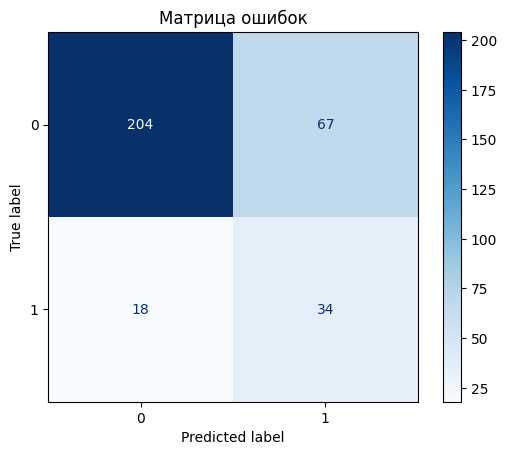


Feature Importances:
                                            feature  importance
8                  Полных лет на момент поступления    0.175148
1                            Cумма баллов испытаний    0.070595
17                                          Заочная    0.035198
0                                         Приоритет    0.000000
2                                               БВИ    0.000000
4                                          Контракт    0.000000
3                           Балл за инд. достижения    0.000000
6                      Иностранный абитуриент (МОН)    0.000000
5                             Нуждается в общежитии    0.000000
9                                  fromEkaterinburg    0.000000
10                             fromSverdlovskRegion    0.000000
11                          Human Development Index    0.000000
7                                               Пол    0.000000
12                                     Особая квота    0.000000
13                

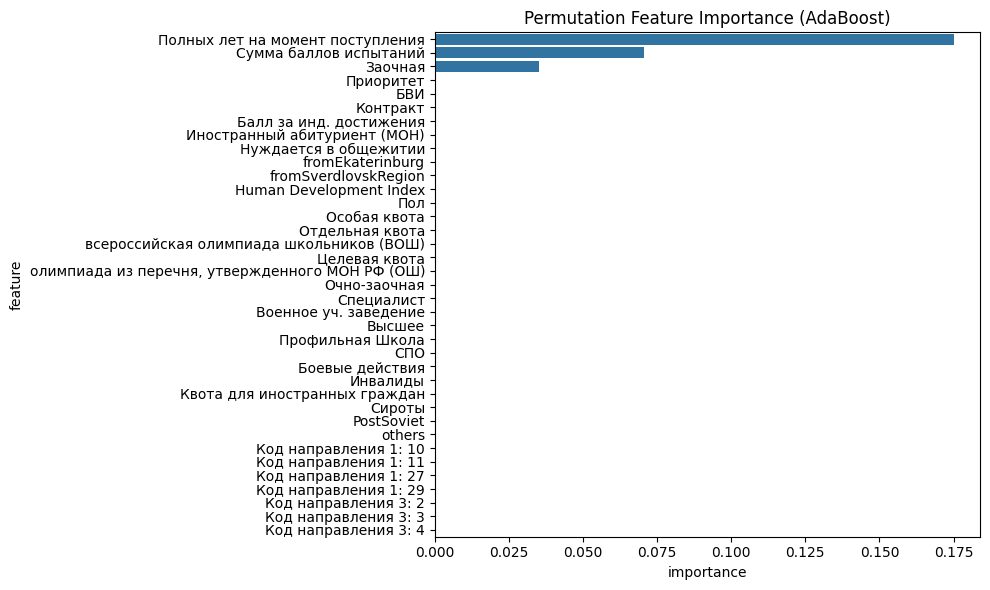

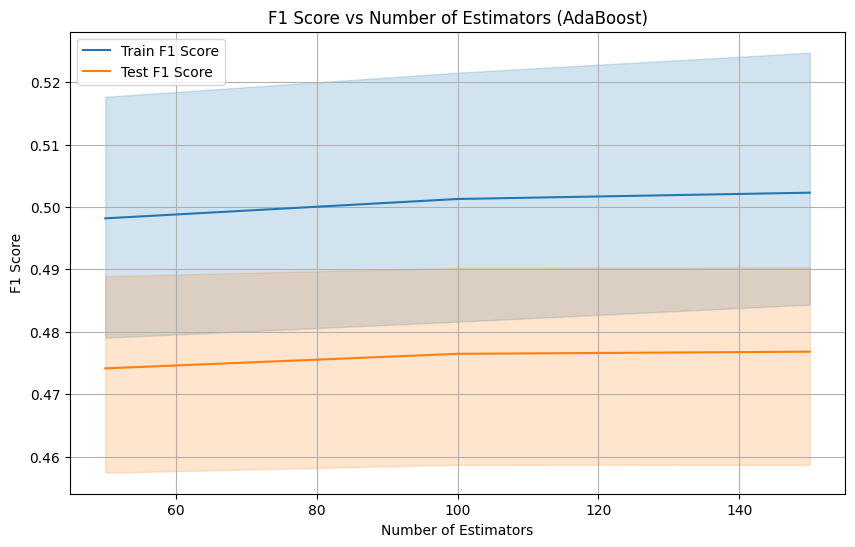

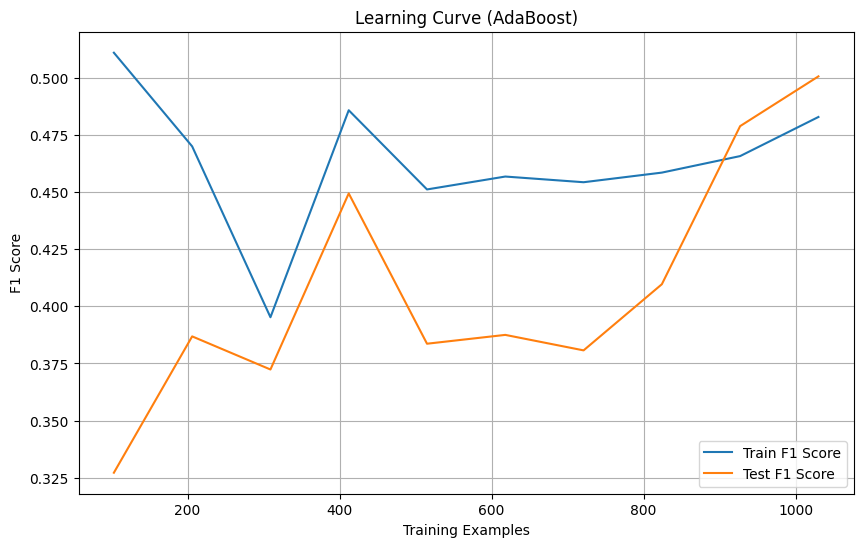

In [31]:
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import permutation_importance
import numpy as np
import os

save_dir = 'adaboost/c1_bak_spec'
os.makedirs(save_dir, exist_ok=True)

pipeline = Pipeline([
    ('clf', AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=1, class_weight='balanced'),
        random_state=42
    ))
])

param_grid = {
    'clf__n_estimators': [50, 100, 150],
    'clf__learning_rate': [0.01, 0.1, 0.5, 1.0],
    'clf__estimator__max_depth': [2, 3]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1, return_train_score=True)
grid_search.fit(X_train_c1_bak_spec, y_train_c1_bak_spec)

y_pred = grid_search.predict(X_test_c1_bak_spec)
best_model = grid_search.best_estimator_
joblib.dump(best_model, '../../data/models/adaboost_model_c1_bak_spec.joblib')

print("Лучшие параметры:", grid_search.best_params_)
print("Лучшая модель:", best_model)
print("\nОтчёт классификации:\n", classification_report(y_test_c1_bak_spec, y_pred))

cm = confusion_matrix(y_test_c1_bak_spec, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.named_steps['clf'].classes_)
disp.plot(cmap="Blues")
plt.title("Матрица ошибок")
plt.savefig(os.path.join(save_dir, "confusion_matrix_adaboost.png"))
plt.show()

result = permutation_importance(
    best_model,
    X_test_c1_bak_spec,
    y_test_c1_bak_spec,
    scoring='f1',
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

importances = result.importances_mean
features = X_train_c1_bak_spec.columns

feature_importances = pd.DataFrame({
    'feature': features,
    'importance': importances
}).sort_values('importance', ascending=False)

print("\nFeature Importances:")
print(feature_importances)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importances)
plt.title("Permutation Feature Importance (AdaBoost)")
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "feature_importance_adaboost.png"))
plt.show()

results = pd.DataFrame(grid_search.cv_results_)
results_filtered = results[[
    'param_clf__n_estimators',
    'mean_train_score',
    'mean_test_score'
]].copy()
results_filtered['param_clf__n_estimators'] = pd.to_numeric(results_filtered['param_clf__n_estimators'])

plt.figure(figsize=(10, 6))
sns.lineplot(data=results_filtered, x='param_clf__n_estimators', y='mean_train_score', label='Train F1 Score')
sns.lineplot(data=results_filtered, x='param_clf__n_estimators', y='mean_test_score', label='Test F1 Score')
plt.title('F1 Score vs Number of Estimators (AdaBoost)')
plt.xlabel('Number of Estimators')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(save_dir, "f1_vs_estimators_adaboost.png"))
plt.show()

train_sizes, train_scores, test_scores = learning_curve(
    estimator=best_model,
    X=X_train_c1_bak_spec,
    y=y_train_c1_bak_spec,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='f1',
    n_jobs=-1
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Train F1 Score')
plt.plot(train_sizes, test_scores_mean, label='Test F1 Score')
plt.title('Learning Curve (AdaBoost)')
plt.xlabel('Training Examples')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(save_dir, "learning_curve_adaboost.png"))
plt.show()

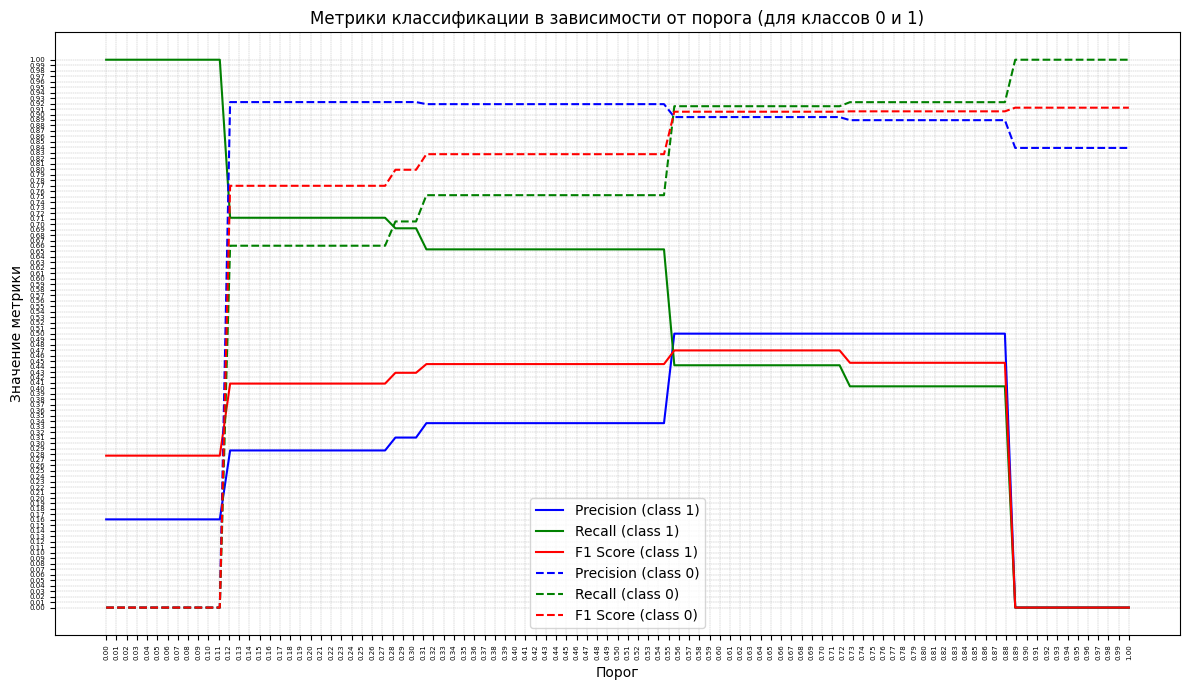

In [32]:
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np
import os

y_probs = grid_search.predict_proba(X_test_c1_bak_spec)[:, 1]

thresholds = np.linspace(0, 1, 100)

precisions_1, recalls_1, f1_scores_1 = [], [], []
precisions_0, recalls_0, f1_scores_0 = [], [], []

for thresh in thresholds:
    y_pred_thresh = (y_probs >= thresh).astype(int)

    precisions_1.append(precision_score(y_test_c1_bak_spec, y_pred_thresh, pos_label=1, zero_division=0))
    recalls_1.append(recall_score(y_test_c1_bak_spec, y_pred_thresh, pos_label=1, zero_division=0))
    f1_scores_1.append(f1_score(y_test_c1_bak_spec, y_pred_thresh, pos_label=1, zero_division=0))

    precisions_0.append(precision_score(y_test_c1_bak_spec, y_pred_thresh, pos_label=0, zero_division=0))
    recalls_0.append(recall_score(y_test_c1_bak_spec, y_pred_thresh, pos_label=0, zero_division=0))
    f1_scores_0.append(f1_score(y_test_c1_bak_spec, y_pred_thresh, pos_label=0, zero_division=0))

save_path = 'adaboost/c1_bak_spec'

plt.figure(figsize=(12, 7))

plt.plot(thresholds, precisions_1, label='Precision (class 1)', color='blue')
plt.plot(thresholds, recalls_1, label='Recall (class 1)', color='green')
plt.plot(thresholds, f1_scores_1, label='F1 Score (class 1)', color='red')

plt.plot(thresholds, precisions_0, '--', label='Precision (class 0)', color='blue')
plt.plot(thresholds, recalls_0, '--', label='Recall (class 0)', color='green')
plt.plot(thresholds, f1_scores_0, '--', label='F1 Score (class 0)', color='red')

plt.xticks(np.arange(0, 1.01, 0.01), rotation=90, fontsize=5)
plt.yticks(np.arange(0, 1.01, 0.01), fontsize=5)
plt.grid(True, which='both', linestyle='--', linewidth=0.3)

plt.xlabel('Порог')
plt.ylabel('Значение метрики')
plt.title('Метрики классификации в зависимости от порога (для классов 0 и 1)')
plt.legend()
plt.tight_layout()

plt.savefig(os.path.join(save_path, 'metrics_vs_threshold_adaboost.png'), dpi=300)
plt.show()